In [205]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
# data read 
words = open('/home/risal/X3s4c5/Makemore/names.txt','r').read().splitlines()

In [207]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [208]:
# build the dataset
block_size = 3
def build_dataset(words):
    X, Y= [] , []
    
    for w in words:
        context  = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_trn, Y_trn = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_tst, Y_tst = build_dataset(words[n2:])

In [217]:
n_emb = 10
n_hidden = 200

# MLP components 
g = torch.Generator().manual_seed(123)
C = torch.randn((vocab_size,n_emb), generator = g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator = g) * (5/3)/((n_emb * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator = g)  * 0
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g ) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad =  True

12297


In [218]:
# MLP
max_steps = 30000
batch_size = 32
losses_train = []

for i in range(max_steps):
    
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (batch_size,), generator = g)
    Xb, Yb = X_trn[ix], Y_trn[ix]
    
    # forward passes 
    emb = C[Xb] 
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1 #+b1
    # tracking down the batch running mean and std
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch norm formula and scaling and shifting 

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Y_trn[ix]) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    losses_train.append(loss.item())

    # break

      0 /   30000: 3.7188
   1000 /   30000: 2.6986
   2000 /   30000: 2.6447
   3000 /   30000: 2.6479
   4000 /   30000: 2.2837
   5000 /   30000: 2.1756
   6000 /   30000: 2.2292
   7000 /   30000: 2.3475
   8000 /   30000: 2.5768
   9000 /   30000: 2.2566
  10000 /   30000: 2.3386
  11000 /   30000: 2.6710
  12000 /   30000: 2.8111
  13000 /   30000: 2.7230
  14000 /   30000: 2.4936
  15000 /   30000: 2.1004
  16000 /   30000: 2.8339
  17000 /   30000: 2.6180
  18000 /   30000: 2.2810
  19000 /   30000: 2.3387
  20000 /   30000: 2.1461
  21000 /   30000: 2.3007
  22000 /   30000: 2.7087
  23000 /   30000: 2.0883
  24000 /   30000: 2.7624
  25000 /   30000: 1.9302
  26000 /   30000: 2.6192
  27000 /   30000: 2.2375
  28000 /   30000: 2.0085
  29000 /   30000: 2.1024


In [219]:
bnmean

tensor([[ 0.0223, -0.6618, -0.5731,  0.4192,  0.1605, -0.8547, -0.7391,  0.6324,
         -0.7553, -0.5039, -0.1761, -0.6999, -0.4937, -0.2823,  0.4362, -0.4203,
         -0.9169, -0.2190,  0.1865, -0.1507, -0.5304, -0.1457,  0.1160, -0.2898,
         -0.0368, -0.2800, -0.3027,  0.8285,  0.0504,  0.4549,  0.1307,  0.2023,
         -0.4611, -0.9046,  0.4304, -0.9926, -0.7489,  0.4007, -0.1349, -0.3541,
         -0.4252,  0.1086, -0.1958,  0.0126,  0.6988,  0.9469,  1.0195, -0.2858,
         -0.6456,  0.5835,  0.1763, -0.4587, -0.5309,  0.1338, -0.3592,  0.2038,
          0.7529,  0.3834, -0.7968,  0.0363,  0.7494, -0.0719, -0.8505, -0.3780,
         -0.3505,  0.0141, -0.8263,  0.5192, -1.0336, -0.0030, -0.0963, -0.3771,
         -0.6781,  0.2040,  0.1863,  0.2675, -0.0590, -0.5839, -0.5545,  0.4280,
          0.0979,  0.1420,  0.4135,  0.2038,  0.1949, -0.7347, -0.5295, -0.0417,
         -0.1049, -0.6100, -0.1783, -0.1822, -0.0077, -0.4197, -0.5773, -0.3743,
          0.6711, -0.4257, -

In [220]:
bnmean_running

tensor([[ 0.0243, -0.6780, -0.5688,  0.4195,  0.1662, -0.8555, -0.7359,  0.6416,
         -0.7604, -0.5003, -0.1704, -0.6919, -0.4910, -0.2869,  0.4440, -0.4114,
         -0.9121, -0.2133,  0.1837, -0.1372, -0.5316, -0.1418,  0.1249, -0.2864,
         -0.0312, -0.2865, -0.3065,  0.8289,  0.0581,  0.4614,  0.1317,  0.2036,
         -0.4584, -0.9038,  0.4413, -0.9909, -0.7480,  0.4016, -0.1368, -0.3599,
         -0.4126,  0.1024, -0.1883,  0.0220,  0.6986,  0.9479,  1.0376, -0.2818,
         -0.6408,  0.5737,  0.1759, -0.4650, -0.5312,  0.1363, -0.3549,  0.1978,
          0.7462,  0.3783, -0.8039,  0.0293,  0.7460, -0.0642, -0.8485, -0.3717,
         -0.3645,  0.0056, -0.8122,  0.5245, -1.0411,  0.0036, -0.0900, -0.3694,
         -0.6723,  0.1916,  0.1883,  0.2710, -0.0551, -0.5710, -0.5505,  0.4291,
          0.1006,  0.1434,  0.4064,  0.2056,  0.1992, -0.7350, -0.5299, -0.0326,
         -0.1074, -0.6044, -0.1800, -0.1754, -0.0127, -0.4167, -0.5738, -0.3883,
          0.6751, -0.4248, -

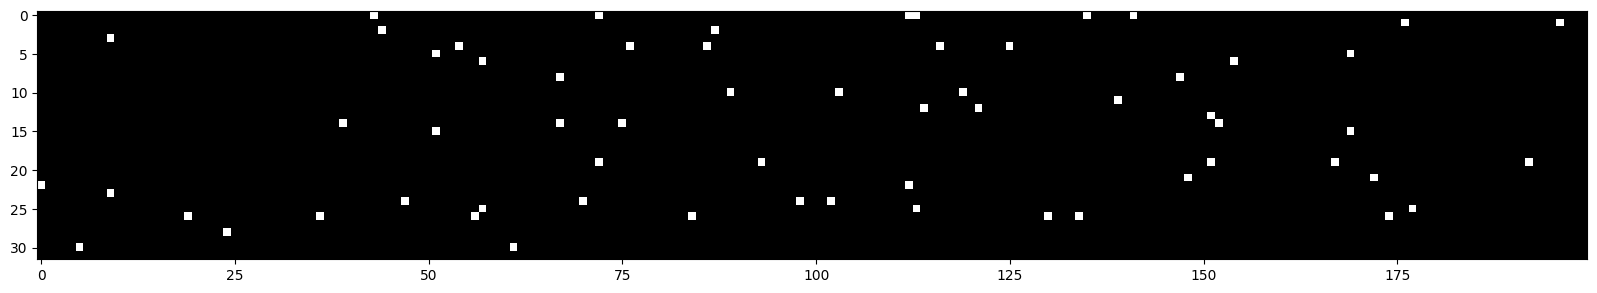

In [211]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

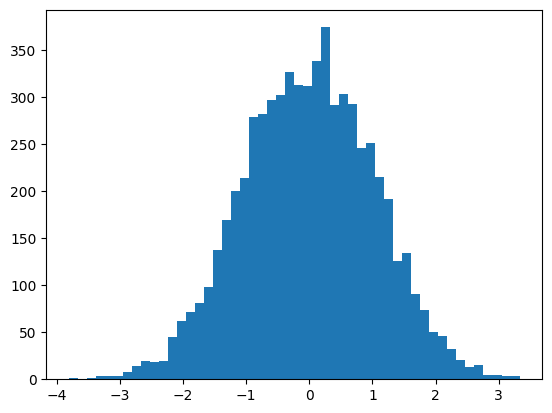

In [212]:
plt.hist(hpreact.view(-1).tolist(), 50);

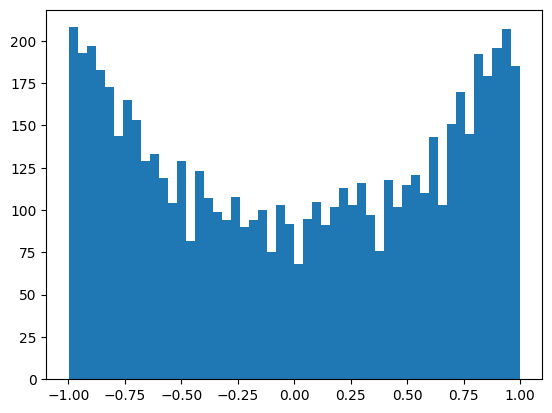

In [213]:
plt.hist(h.view(-1).tolist(), 50);

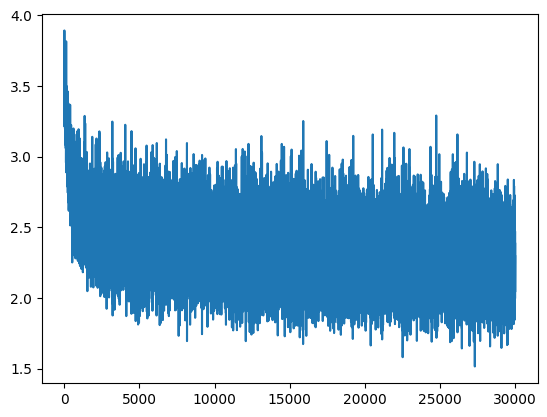

In [214]:
plt.plot(losses_train)

In [215]:
# with torch.no_grad():
#     emb = C[X_trn]
#     embcat = emb.view((emb.shape[0], -1))
#     hpreact = embcat @ W1 + b1
    
#     # Calculating mean and std for entire training 
#     bnmean = hpreact.mean(0, keepdim = True)
#     bnstd = hpreact.std(0, keepdim = True)    

In [216]:
@torch.no_grad()
def split_loss(split):
    X,Y = {
        'train': (X_trn, Y_trn),
        'val' : (X_dev, Y_dev),
        'test' : (X_tst, Y_tst),
    }[split]
    emb = C[X]
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # Batch norm formula and scaling and shifting  
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.230093002319336
val 2.4673449993133545


In [221]:
# Sampling from the model
g  = torch.Generator().manual_seed(123)
for i in range(1):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view((emb.shape[0], -1))
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

awmzkjjmzhvtjswmwkkjpjpjjfjyjfkjzkwjkkjdmazawwfwsjmffpdjuckmkjjzzgpkggehpvdgfkkkgjgujghjqpkwcjmjkjzhjgjzkccwjkqsbzjkkjzkjtjgjbcmkdvcxmgwjsckkjjjhhwjnzhgwjdckkbgkhfcghmaknjahjjvzkkafjzcjmpgdjgeczcwzjkwjjjwmkdtglmkjnjzzgmplhjkhkgjcdjkzfzjkjjbcjymmdsbcpkmkgtjdkkhjjyamjjkzjktjjkjkjjjknmjjzjtjkcjgffjhdzjgckqkangywwfkdkjskyjpckcwcwkajunhjmfkmhzjimssbjlcjdshzjjepgmjjqbzjjgdvjkfwjszkgcajmwjxjjmrapjkpkjmrkjumcjzkszsmjgjalhzmcambkjcezjjpfbzvjzajgpgjvknbfnhmgapqjfhsaztjjgknmaehjqjqkckjzdgfrgkjpkjkmhsjjjnmqbjkpkkjkkkkjgjjkpnzjjskemgnjkjobkfkafksppmmfjfgzbkjkgfjzfjkhkkjjcbsjzjktdagjkpzjdczmdwgofjsjmkmwmcdbggzmokkjjglcvrwxkkmjkfjfpzfqmjmjsgznfmkuakbfdccjhmkkjybgkjhjdcgfkpjkgfdjskzvkrohjgjzbgjmgkblygjkejkdjumkhjjjkkjjargjgpkkxbjfkwdbjapfzzjwfgxkjwjgjttbtmwvjffgpmgwfmkpbnjkfjjfqmsvkjgzjhvffzjkjjadbhzjjwfkskjjjsbjmsjjptzjkjgkmgnswpwntkujgkmbgzcwckakzkvjznjphazowgakjhdkaxukqjjwjjfjcjfzrjjhkfgkipjsjkshjjmmamcjbmgjmxpjyzajjkkjjjzjjkmhabgbjmkyzgjjgnjdkgjjecjgjkjksgmqeknmkbpjkfjzkhjggddjbgvgpgvkpvrghwjjgjks